1. Загрузка библиотек и настройка параметров

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, \
    roc_curve, auc
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import os
import random

In [2]:
# Фиксация всех случайных seed для воспроизводимости
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # если используются многопоточные GPU
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(SEED)  # если используется стандартный модуль random


# Для воспроизводимости DataLoader при использовании многопоточности
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


g = torch.Generator()
g.manual_seed(SEED)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

2. Подготовка и предобработка данных

2.1. Датасеты

В статье используются публичные датасеты, содержащие как нормальный сетевой трафик, так и аномальные/злоумышленные потоки. Например, можно попробовать использовать:

- USTC-TFC (University of Science and Technology of China – Traffic Flow Collection)

- Другие датасеты для сетевого обнаружения аномалий

2.2. Предобработка

Согласно статье, на вход модели подаются первые n пакетов каждого сетевого потока, причем:

- Фильтрация: Выбираются пакеты, принадлежащие одному 5-тuple (IP-адреса, порты, протокол).

- Анонимизация: MAC- и IP-адреса маскируются.

- Трансформация: Каждый пакет приводится к фиксированной длине l (если пакет длиннее – усечение, если короче – дополнение нулями).

- Нормализация: Значения байтов нормализуются (например, делением на 255).

- Конкатенация: n пакетов объединяются в единый входной вектор.

Пример кода для обработки может выглядеть следующим образом (упрощённо):

In [4]:
# Класс Dataset для загрузки данных из CSV
class CSVAttackDataset(Dataset):
    def __init__(self, attack_dir, data_type='normal', transform=None):
        """
        attack_dir: путь к папке с CSV-файлами атаки (например, 'sql-inj')
        data_type: 'attack' или 'normal'
        """
        self.file_path = os.path.join(attack_dir, f"{os.path.basename(attack_dir)}_{data_type}.csv")
        self.data = self._load_and_filter_data()
        self.transform = transform

    def _load_and_filter_data(self):
        if not os.path.exists(self.file_path):
            return pd.DataFrame()

        df = pd.read_csv(self.file_path)
        # Фильтрация данных (для обучения используем только нормальный трафик)
        df = df[df['label'] == 0] if 'normal' in self.file_path else df
        return df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        # Извлекаем байты и нормализуем в [0, 1]
        features = sample.filter(like='byte_').values.astype(np.float32) / 255.0
        tensor = torch.tensor(features, dtype=torch.float32)
        # Добавляем размерность канала: [1, input_length]
        return tensor.unsqueeze(0)

In [5]:
# Класс для комбинированного тестового набора
class CombinedTestDataset(Dataset):
    def __init__(self, attack_dir):
        attack_df = pd.read_csv(os.path.join(attack_dir, f"{os.path.basename(attack_dir)}_attack.csv"))
        normal_df = pd.read_csv(os.path.join(attack_dir, f"{os.path.basename(attack_dir)}_normal.csv"))
        self.data = pd.concat([attack_df, normal_df], ignore_index=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        features = sample.filter(like='byte_').values.astype(np.float32) / 255.0
        label = sample['label']
        return torch.tensor(features).unsqueeze(0), torch.tensor(label, dtype=torch.float32)

3. Модель и архитектура

ARCADE состоит из двух компонентов:

3.1. Автоэнкодер (AE)

Используется компактная свёрточная архитектура (inspired by DCGAN) для кодирования и декодирования входных сетевых потоков.

Основная идея:

- Encoder: Преобразует входной сигнал в компактное латентное представление.

- Decoder: Восстанавливает исходный сигнал из латентного представления.

3.2. Критик (Critic)

Отдельная нейросеть, выполняющая роль дискриминатора (как в WGAN-GP), оценивающая, насколько реконструкция (выход AE) соответствует нормальному распределению трафика. При обучении используется штраф за градиент (gradient penalty) для соблюдения условий липшицевости.

In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
                # Input: (batch, 1, 200)
                nn.Conv1d(1, 16, kernel_size=4, stride=2, padding=1),  # Output: (16, 100)
                nn.BatchNorm1d(16),
                nn.LeakyReLU(),

                nn.Conv1d(16, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 50)
                nn.BatchNorm1d(32),
                nn.LeakyReLU(),

                nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 25)
                nn.BatchNorm1d(64),
                nn.LeakyReLU(),

                nn.Flatten(),
                nn.Linear(64 * 25, 50, bias=False)  # Parameters: 64*25*50 = 80,000
                )

    def forward(self, x):
        return self.model(x)

In [7]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
                # Input: (batch, 50)
                nn.Linear(50, 64 * 25, bias=False),  # Parameters: 50*64*25 = 80,000
                nn.Unflatten(1, (64, 25)),  # Reshape to (64, 25)

                nn.BatchNorm1d(64),
                nn.ReLU(),

                nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 50)
                nn.BatchNorm1d(32),
                nn.ReLU(),

                nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),  # Output: (16, 100)
                nn.BatchNorm1d(16),
                nn.ReLU(),

                nn.ConvTranspose1d(16, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 200)
                nn.Sigmoid()
                )

    def forward(self, x):
        return self.model(x)

In [8]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction

In [9]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()

        self.model = nn.Sequential(
                # Input: (batch, 1, 200)
                nn.Conv1d(1, 16, kernel_size=4, stride=2, padding=1),  # Output: (16, 100)
                nn.LayerNorm([16, 100]),
                nn.LeakyReLU(),

                nn.Conv1d(16, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 50)
                nn.LayerNorm([32, 50]),
                nn.LeakyReLU(),

                nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 25)
                nn.LayerNorm([64, 25]),
                nn.LeakyReLU(),

                nn.Flatten(),
                nn.Linear(64 * 25, 50, bias=False),  # Parameters: 64*25*50 = 80,000
                nn.LayerNorm(50),
                nn.LeakyReLU(),

                nn.Linear(50, 1, bias=False)  # Parameters: 50*1 = 50
                )

    def forward(self, x):
        return self.model(x)

4. Функции потерь и штраф за градиент

4.1. Функция реконструкции

Чаще всего используется MSE (Mean Squared Error) или L1 loss:

4.2. Adversarial loss (WGAN-GP)

Критик обучается по следующему принципу:

- Максимизировать оценку для реальных нормальных потоков.

- Минимизировать оценку для реконструкций, полученных автоэнкодером.

При этом применяется штраф за градиент, как описано в статье (см. уравнение (4)).

Пример функции для расчёта gradient penalty:

In [10]:
def compute_gradient_penalty(critic, real_data, fake_data, device, lambda_gp=10):
    batch_size = real_data.size(0)
    alpha = torch.rand(batch_size, 1, 1, device=device)
    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates.requires_grad_(True)
    critic_interpolates = critic(interpolates)
    gradients = grad(
            outputs=critic_interpolates,
            inputs=interpolates,
            grad_outputs=torch.ones_like(critic_interpolates, device=device),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
            )[0]
    gradients = gradients.view(batch_size, -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_gp
    return gradient_penalty

5. Процедура обучения

5.1. Стратегия обучения

Архитектура обучается по схеме adversarial training:

- Шаг 1. Обучение критика:
    - Используйте реальные нормальные данные и реконструкции автоэнкодера.

    - Обновляйте веса критика, максимизируя разницу между оценками (реальные – реконструированные), добавляя штраф за градиент.

- Шаг 2. Обучение автоэнкодера:

    - Минимизируйте комбинированную функцию потерь, состоящую из ошибки реконструкции и adversarial loss (то есть, ошибка между оценкой критика для реконструкций и целевым значением).

5.2. Пример цикла обучения

Ниже приведён псевдокод, демонстрирующий общий цикл обучения:

In [11]:
def evaluate_validation(autoencoder, val_loader, device, reconstruction_criterion):
    autoencoder.eval()
    val_loss = 0.0
    count = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            reconstruction = autoencoder(data)
            loss = reconstruction_criterion(reconstruction, data)
            val_loss += loss.item() * data.size(0)
            count += data.size(0)
    autoencoder.train()
    return val_loss / count

In [12]:
def train_arcade(autoencoder, critic, train_loader, val_loader, device,
                 searching_epochs=100, fine_tuning_epochs=50,
                 lr_searching=1e-4, lr_finetuning=1e-5,
                 lambda_gp=10, lambda_adv=0.01,
                 critic_iters=5,
                 balance_threshold=0.001, balance_patience=5,
                 early_stopping_patience=10
                 ):
    total_epochs = searching_epochs + fine_tuning_epochs

    # Инициализация оптимизаторов с β1=0, β2=0.9
    optimizer_AE = optim.Adam(autoencoder.parameters(), lr=lr_searching, betas=(0, 0.9))
    optimizer_Critic = optim.Adam(critic.parameters(), lr=lr_searching, betas=(0, 0.9))

    reconstruction_criterion = nn.MSELoss()

    best_val_loss = float('inf')
    epochs_without_improvement = 0
    balance_counter = 0  # Количество последовательных эпох, когда разница лоссов меньше порога

    epoch = 0
    while epoch < total_epochs:
        total_loss_ae = 0.0
        total_loss_critic = 0.0
        num_batches = 0

        # Если перешли в фазу fine-tuning, обновляем lr оптимизаторов
        if epoch == searching_epochs:
            for param_group in optimizer_AE.param_groups:
                param_group['lr'] = lr_finetuning
            for param_group in optimizer_Critic.param_groups:
                param_group['lr'] = lr_finetuning

        batch_pbar = tqdm(enumerate(train_loader), total=len(train_loader),
                          desc=f"Epoch {epoch + 1}/{total_epochs}", unit="batch"
                          )
        for i, real_data in batch_pbar:
            real_data = real_data.to(device)

            # Обновление критика (несколько итераций)
            critic_loss_epoch = 0.0
            for _ in range(critic_iters):
                optimizer_Critic.zero_grad()
                reconstruction = autoencoder(real_data)
                critic_real = critic(real_data)
                critic_fake = critic(reconstruction.detach())
                gp = compute_gradient_penalty(critic, real_data, reconstruction.detach(), device, lambda_gp)
                loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake)) + gp
                loss_critic.backward()
                optimizer_Critic.step()
                critic_loss_epoch += loss_critic.item()
            avg_critic_loss = critic_loss_epoch / critic_iters

            # Обновление автоэнкодера
            optimizer_AE.zero_grad()
            reconstruction = autoencoder(real_data)
            loss_reconstruction = reconstruction_criterion(reconstruction, real_data)
            loss_adv = -torch.mean(critic(reconstruction))
            loss_AE = loss_reconstruction + lambda_adv * loss_adv
            loss_AE.backward()
            optimizer_AE.step()

            total_loss_ae += loss_AE.item()
            total_loss_critic += avg_critic_loss
            num_batches += 1

            batch_pbar.set_postfix({
                    "MSE Loss"   : f"{loss_reconstruction:.4f}",
                    "AE Loss"    : f"{loss_AE.item():.4f}",
                    "Critic Loss": f"{avg_critic_loss:.4f}"
                    }
                    )
        batch_pbar.close()

        avg_ae_loss = total_loss_ae / num_batches
        avg_critic_loss = total_loss_critic / num_batches

        # Проверка условия балансировки лоссов
        if abs(avg_ae_loss - avg_critic_loss) < balance_threshold:
            balance_counter += 1
        else:
            balance_counter = 0

        # Вычисляем ошибку на валидационном наборе
        val_loss = evaluate_validation(autoencoder, val_loader, device, reconstruction_criterion)
        print(
                f"- Epoch {epoch + 1}: Avg AE Loss = {avg_ae_loss:.4f}, Avg Critic Loss = {avg_critic_loss:.4f}, Val Loss = {val_loss:.4f}"
                )

        # Раннее прекращение по валидации
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # Если баланс достигнут в течение balance_patience эпох или нет улучшения валидации
        if balance_counter >= balance_patience:
            print("Баланс между лоссами достигнут, остановка обучения.")
            break
        if epochs_without_improvement >= early_stopping_patience:
            print("Нет улучшения на валидации, early stopping.")
            break

        epoch += 1
    print("Обучение завершено.")

In [13]:
def evaluate_metrics(autoencoder, dataloader, device):
    all_scores = []
    all_labels = []
    autoencoder.eval()

    # Сбор ошибок реконструкции и меток для всех примеров
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            reconstruction = autoencoder(data)
            # Вычисление ошибки реконструкции (например, среднеквадратичная ошибка по каждому примеру)
            scores = torch.mean((data - reconstruction) ** 2, dim=[1, 2]).cpu().numpy()
            all_scores.extend(scores)
            all_labels.extend(labels.cpu().numpy())

    all_scores = np.array(all_scores)
    all_labels = np.array(all_labels)

    # Вычисление AUROC без пороговой бинаризации
    auroc = roc_auc_score(all_labels, all_scores)

    # Подбор порога на основе максимизации F1-метрики
    thresholds = np.linspace(np.min(all_scores), np.max(all_scores), num=100)
    f1_scores = []
    for thr in thresholds:
        preds = (all_scores > thr).astype(int)
        f1 = f1_score(all_labels, preds)
        f1_scores.append(f1)
    best_threshold = thresholds[np.argmax(f1_scores)]

    # Применение оптимального порога для вычисления остальных метрик
    predictions = (all_scores > best_threshold).astype(int)
    accuracy = accuracy_score(all_labels, predictions)
    precision = precision_score(all_labels, predictions)
    recall = recall_score(all_labels, predictions)
    f1 = f1_score(all_labels, predictions)

    # Вычисление матрицы ошибок
    tn, fp, fn, tp = confusion_matrix(all_labels, predictions).ravel()

    print(f"AUROC: {auroc:.4f}")
    print(f"Лучший threshold: {best_threshold:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"Матрица ошибок:")
    print(f"TN: {tn:.4f}")
    print(f"FP: {fp:.4f}")
    print(f"FN: {fn:.4f}")
    print(f"TP: {tp:.4f}")

    # ------------------ Построение графиков ------------------

    # 1. Гистограмма распределения ошибок реконструкции
    plt.figure(figsize=(12, 5))
    plt.hist(all_scores[all_labels == 0], bins=50, alpha=0.6, label='Нормальные')
    plt.hist(all_scores[all_labels == 1], bins=50, alpha=0.6, label='Аномалии')
    plt.axvline(best_threshold, color='red', linestyle='--', label=f'Лучший threshold: {best_threshold:.4f}')
    plt.xlabel('Ошибка реконструкции')
    plt.ylabel('Количество примеров')
    plt.title('Распределение ошибок реконструкции')
    plt.legend()
    plt.show()

    # 2. ROC-кривая
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'ROC кривая (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC кривая')
    plt.legend(loc='lower right')
    plt.show()

    # 3. Зависимость F1-score от порога
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, f1_scores, marker='o')
    plt.xlabel('Threshold')
    plt.ylabel('F1-score')
    plt.title('Зависимость F1-score от порога')
    plt.axvline(best_threshold, color='red', linestyle='--', label=f'Лучший threshold: {best_threshold:.4f}')
    plt.legend()
    plt.show()

    return auroc, predictions, accuracy, precision, recall, f1, tn, fp, fn, tp, roc_auc

In [14]:
results = []

In [15]:
def train_attack_category(distribution, base_dir='ARP-STP-n_packets=2_l=100'):
    print(f"\n< ---------- {distribution} ---------- >")

    # Создаем Dataset только для нормального трафика для обучения
    train_dataset = CSVAttackDataset(
            attack_dir=os.path.join(base_dir, distribution),
            data_type='normal'
            )

    # Разбиение на train/validation
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    # Тестовый набор (attack + normal)
    test_dataset = CombinedTestDataset(os.path.join(base_dir, distribution))

    # Создаем DataLoader-ы
    batch_size = 32

    train_dataloader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            worker_init_fn=seed_worker,  # <- для воркеров
            generator=g,  # <- для перемешивания
            num_workers=4
            )

    val_dataloader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            worker_init_fn=seed_worker,  # важно, если есть аугментации
            generator=g  # не влияет при shuffle=False, но для единообразия
            )

    test_dataloader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            worker_init_fn=seed_worker,  # если есть преобразования данных
            generator=g  # можно опустить, но лучше оставить
            )

    # Инициализация моделей
    autoencoder = Autoencoder().to(device)
    critic = Critic().to(device)

    # Обучение ARCADE
    searching_epochs = 10  # Фаза "searching"
    fine_tuning_epochs = 5  # Фаза "fine-tuning"
    train_arcade(autoencoder, critic, train_dataloader, val_dataloader, device)

    # Оценка и сохранение метрик
    auroc, predictions, accuracy, precision, recall, f1, tn, fp, fn, tp, roc_auc = evaluate_metrics(
            autoencoder,
            test_dataloader,
            device
            )

    # Добавляем результат в список
    results.append({
            'Distribution'  : distribution,
            'AUROC'         : auroc,
            'Accuracy'      : accuracy,
            'Precision'     : precision,
            'Recall'        : recall,
            'F1 Score'      : f1,
            'True Negative' : tn,
            'False Positive': fp,
            'False Negative': fn,
            'True Positive' : tp,
            'ROC AUC'       : roc_auc
            }
            )
    print()


< ---------- cauchy ---------- >


Epoch 1/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 1: Avg AE Loss = 0.1332, Avg Critic Loss = -4.4865, Val Loss = 0.0557


Epoch 2/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 2: Avg AE Loss = 0.0544, Avg Critic Loss = -2.6948, Val Loss = 0.0180


Epoch 3/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 3: Avg AE Loss = 0.0243, Avg Critic Loss = -1.4813, Val Loss = 0.0067


Epoch 4/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 4: Avg AE Loss = 0.0047, Avg Critic Loss = -0.5949, Val Loss = 0.0005


Epoch 5/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 5: Avg AE Loss = -0.0047, Avg Critic Loss = -0.2048, Val Loss = 0.0001


Epoch 6/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 6: Avg AE Loss = -0.0081, Avg Critic Loss = -0.0647, Val Loss = 0.0000


Epoch 7/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 7: Avg AE Loss = -0.0097, Avg Critic Loss = -0.0160, Val Loss = 0.0000


Epoch 8/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 8: Avg AE Loss = -0.0116, Avg Critic Loss = -0.0019, Val Loss = 0.0000


Epoch 9/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 9: Avg AE Loss = -0.0133, Avg Critic Loss = 0.0010, Val Loss = 0.0000


Epoch 10/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 10: Avg AE Loss = -0.0149, Avg Critic Loss = 0.0013, Val Loss = 0.0000


Epoch 11/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 11: Avg AE Loss = -0.0162, Avg Critic Loss = 0.0013, Val Loss = 0.0000


Epoch 12/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 12: Avg AE Loss = -0.0173, Avg Critic Loss = 0.0011, Val Loss = 0.0000


Epoch 13/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 13: Avg AE Loss = -0.0184, Avg Critic Loss = 0.0010, Val Loss = 0.0000


Epoch 14/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 14: Avg AE Loss = -0.0199, Avg Critic Loss = 0.0010, Val Loss = 0.0000


Epoch 15/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 15: Avg AE Loss = -0.0211, Avg Critic Loss = 0.0009, Val Loss = 0.0000


Epoch 16/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 16: Avg AE Loss = -0.0221, Avg Critic Loss = 0.0008, Val Loss = 0.0000


Epoch 17/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 17: Avg AE Loss = -0.0229, Avg Critic Loss = 0.0007, Val Loss = 0.0000


Epoch 18/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 18: Avg AE Loss = -0.0236, Avg Critic Loss = 0.0007, Val Loss = 0.0000


Epoch 19/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 19: Avg AE Loss = -0.0238, Avg Critic Loss = 0.0007, Val Loss = 0.0000


Epoch 20/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 20: Avg AE Loss = -0.0240, Avg Critic Loss = 0.0006, Val Loss = 0.0000


Epoch 21/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 21: Avg AE Loss = -0.0244, Avg Critic Loss = 0.0006, Val Loss = 0.0000


Epoch 22/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 22: Avg AE Loss = -0.0246, Avg Critic Loss = 0.0006, Val Loss = 0.0000


Epoch 23/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 23: Avg AE Loss = -0.0247, Avg Critic Loss = 0.0006, Val Loss = 0.0000


Epoch 24/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 24: Avg AE Loss = -0.0247, Avg Critic Loss = 0.0005, Val Loss = 0.0000


Epoch 25/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 25: Avg AE Loss = -0.0245, Avg Critic Loss = 0.0005, Val Loss = 0.0000


Epoch 26/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 26: Avg AE Loss = -0.0242, Avg Critic Loss = 0.0005, Val Loss = 0.0000


Epoch 27/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 27: Avg AE Loss = -0.0241, Avg Critic Loss = 0.0005, Val Loss = 0.0000


Epoch 28/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 28: Avg AE Loss = -0.0240, Avg Critic Loss = 0.0005, Val Loss = 0.0000


Epoch 29/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 29: Avg AE Loss = -0.0240, Avg Critic Loss = 0.0004, Val Loss = 0.0000


Epoch 30/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 30: Avg AE Loss = -0.0237, Avg Critic Loss = 0.0004, Val Loss = 0.0000


Epoch 31/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 31: Avg AE Loss = -0.0235, Avg Critic Loss = 0.0004, Val Loss = 0.0000


Epoch 32/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 32: Avg AE Loss = -0.0231, Avg Critic Loss = 0.0004, Val Loss = 0.0000


Epoch 33/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 33: Avg AE Loss = -0.0226, Avg Critic Loss = 0.0004, Val Loss = 0.0000


Epoch 34/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 34: Avg AE Loss = -0.0220, Avg Critic Loss = 0.0004, Val Loss = 0.0000


Epoch 35/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 35: Avg AE Loss = -0.0219, Avg Critic Loss = 0.0004, Val Loss = 0.0000


Epoch 36/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 36: Avg AE Loss = -0.0215, Avg Critic Loss = 0.0003, Val Loss = 0.0000


Epoch 37/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 37: Avg AE Loss = -0.0211, Avg Critic Loss = 0.0003, Val Loss = 0.0000


Epoch 38/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 38: Avg AE Loss = -0.0207, Avg Critic Loss = 0.0003, Val Loss = 0.0000


Epoch 39/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 39: Avg AE Loss = -0.0203, Avg Critic Loss = 0.0003, Val Loss = 0.0000


Epoch 40/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 40: Avg AE Loss = -0.0202, Avg Critic Loss = 0.0003, Val Loss = 0.0000


Epoch 41/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 41: Avg AE Loss = -0.0201, Avg Critic Loss = 0.0003, Val Loss = 0.0000


Epoch 42/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 42: Avg AE Loss = -0.0199, Avg Critic Loss = 0.0003, Val Loss = 0.0000


Epoch 43/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 43: Avg AE Loss = -0.0198, Avg Critic Loss = 0.0003, Val Loss = 0.0000


Epoch 44/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 44: Avg AE Loss = -0.0194, Avg Critic Loss = 0.0003, Val Loss = 0.0000


Epoch 45/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 45: Avg AE Loss = -0.0192, Avg Critic Loss = 0.0002, Val Loss = 0.0000


Epoch 46/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 46: Avg AE Loss = -0.0186, Avg Critic Loss = 0.0003, Val Loss = 0.0000


Epoch 47/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 47: Avg AE Loss = -0.0185, Avg Critic Loss = 0.0002, Val Loss = 0.0000


Epoch 48/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 48: Avg AE Loss = -0.0184, Avg Critic Loss = 0.0002, Val Loss = 0.0000


Epoch 49/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 49: Avg AE Loss = -0.0182, Avg Critic Loss = 0.0002, Val Loss = 0.0000


Epoch 50/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 50: Avg AE Loss = -0.0179, Avg Critic Loss = 0.0002, Val Loss = 0.0000


Epoch 51/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 51: Avg AE Loss = -0.0178, Avg Critic Loss = 0.0002, Val Loss = 0.0000


Epoch 52/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 52: Avg AE Loss = -0.0175, Avg Critic Loss = 0.0002, Val Loss = 0.0000


Epoch 53/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 53: Avg AE Loss = -0.0173, Avg Critic Loss = 0.0002, Val Loss = 0.0000


Epoch 54/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 54: Avg AE Loss = -0.0172, Avg Critic Loss = 0.0002, Val Loss = 0.0000


Epoch 55/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 55: Avg AE Loss = -0.0173, Avg Critic Loss = 0.0002, Val Loss = 0.0000


Epoch 56/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 56: Avg AE Loss = -0.0173, Avg Critic Loss = 0.0002, Val Loss = 0.0000


Epoch 57/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 57: Avg AE Loss = -0.0172, Avg Critic Loss = 0.0002, Val Loss = 0.0000


Epoch 58/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 58: Avg AE Loss = -0.0172, Avg Critic Loss = 0.0002, Val Loss = 0.0000


Epoch 59/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 59: Avg AE Loss = -0.0171, Avg Critic Loss = 0.0002, Val Loss = 0.0000


Epoch 60/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 60: Avg AE Loss = -0.0170, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 61/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 61: Avg AE Loss = -0.0170, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 62/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 62: Avg AE Loss = -0.0170, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 63/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 63: Avg AE Loss = -0.0170, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 64/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 64: Avg AE Loss = -0.0169, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 65/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 65: Avg AE Loss = -0.0169, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 66/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 66: Avg AE Loss = -0.0168, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 67/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 67: Avg AE Loss = -0.0166, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 68/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 68: Avg AE Loss = -0.0166, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 69/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 69: Avg AE Loss = -0.0166, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 70/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 70: Avg AE Loss = -0.0167, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 71/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 71: Avg AE Loss = -0.0165, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 72/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 72: Avg AE Loss = -0.0164, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 73/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 73: Avg AE Loss = -0.0164, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 74/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 74: Avg AE Loss = -0.0163, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 75/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 75: Avg AE Loss = -0.0164, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 76/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 76: Avg AE Loss = -0.0162, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 77/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 77: Avg AE Loss = -0.0162, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 78/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 78: Avg AE Loss = -0.0162, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 79/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 79: Avg AE Loss = -0.0162, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 80/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 80: Avg AE Loss = -0.0161, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 81/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 81: Avg AE Loss = -0.0161, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 82/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 82: Avg AE Loss = -0.0162, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 83/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 83: Avg AE Loss = -0.0161, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 84/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 84: Avg AE Loss = -0.0162, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 85/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 85: Avg AE Loss = -0.0161, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 86/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 86: Avg AE Loss = -0.0161, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 87/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 87: Avg AE Loss = -0.0161, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 88/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 88: Avg AE Loss = -0.0162, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 89/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 89: Avg AE Loss = -0.0163, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 90/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 90: Avg AE Loss = -0.0162, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 91/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 91: Avg AE Loss = -0.0161, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 92/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 92: Avg AE Loss = -0.0161, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 93/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 93: Avg AE Loss = -0.0162, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 94/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 94: Avg AE Loss = -0.0162, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 95/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 95: Avg AE Loss = -0.0163, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 96/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 96: Avg AE Loss = -0.0162, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 97/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 97: Avg AE Loss = -0.0162, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 98/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 98: Avg AE Loss = -0.0163, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 99/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 99: Avg AE Loss = -0.0162, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 100/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 100: Avg AE Loss = -0.0162, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 101/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 101: Avg AE Loss = -0.0162, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 102/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 102: Avg AE Loss = -0.0162, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 103/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 103: Avg AE Loss = -0.0162, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 104/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 104: Avg AE Loss = -0.0162, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 105/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 105: Avg AE Loss = -0.0161, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 106/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 106: Avg AE Loss = -0.0162, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 107/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 107: Avg AE Loss = -0.0163, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 108/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 108: Avg AE Loss = -0.0163, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 109/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 109: Avg AE Loss = -0.0163, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 110/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 110: Avg AE Loss = -0.0163, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 111/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 111: Avg AE Loss = -0.0163, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 112/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 112: Avg AE Loss = -0.0163, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 113/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 113: Avg AE Loss = -0.0163, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 114/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 114: Avg AE Loss = -0.0163, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 115/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 115: Avg AE Loss = -0.0163, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 116/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 116: Avg AE Loss = -0.0163, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 117/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 117: Avg AE Loss = -0.0163, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 118/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 118: Avg AE Loss = -0.0162, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 119/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 119: Avg AE Loss = -0.0162, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 120/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 120: Avg AE Loss = -0.0162, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 121/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 121: Avg AE Loss = -0.0163, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 122/150:   0%|          | 0/451 [00:00<?, ?batch/s]

- Epoch 122: Avg AE Loss = -0.0163, Avg Critic Loss = 0.0000, Val Loss = 0.0000
Нет улучшения на валидации, early stopping.
Обучение завершено.
AUROC: 0.7347
Лучший threshold: 0.0000
Accuracy: 0.8375
Precision: 0.9929
Recall: 0.6821
F1: 0.8086
Матрица ошибок:
TN: 15941.0000
FP: 79.0000
FN: 5163.0000
TP: 11076.0000


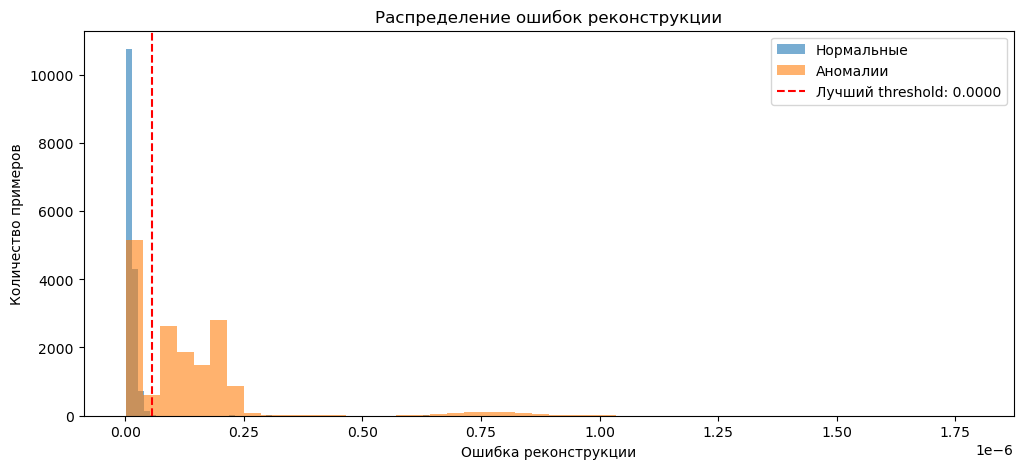

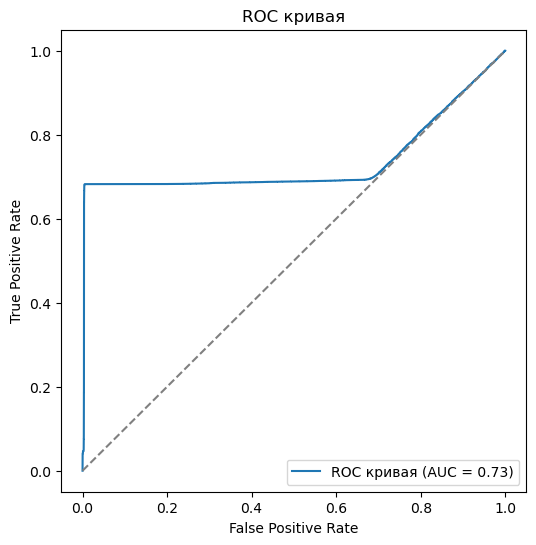

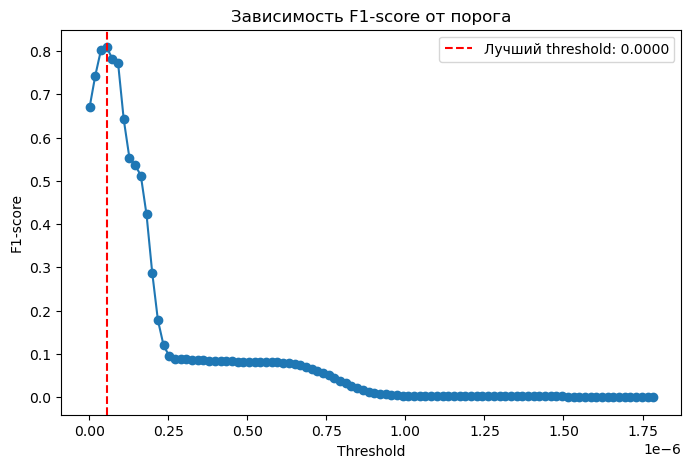

In [16]:
train_attack_category('cauchy')


< ---------- gamma ---------- >


Epoch 1/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 1: Avg AE Loss = 0.2463, Avg Critic Loss = -6.3027, Val Loss = 0.1455


Epoch 2/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 2: Avg AE Loss = 0.1322, Avg Critic Loss = -4.9763, Val Loss = 0.0673


Epoch 3/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 3: Avg AE Loss = 0.0684, Avg Critic Loss = -3.1414, Val Loss = 0.0293


Epoch 4/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 4: Avg AE Loss = 0.0316, Avg Critic Loss = -1.7949, Val Loss = 0.0072


Epoch 5/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 5: Avg AE Loss = 0.0050, Avg Critic Loss = -0.6289, Val Loss = 0.0006


Epoch 6/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 6: Avg AE Loss = -0.0060, Avg Critic Loss = -0.2133, Val Loss = 0.0001


Epoch 7/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 7: Avg AE Loss = -0.0110, Avg Critic Loss = -0.0663, Val Loss = 0.0000


Epoch 8/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 8: Avg AE Loss = -0.0139, Avg Critic Loss = -0.0160, Val Loss = 0.0000


Epoch 9/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 9: Avg AE Loss = -0.0163, Avg Critic Loss = -0.0020, Val Loss = 0.0000


Epoch 10/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 10: Avg AE Loss = -0.0178, Avg Critic Loss = 0.0008, Val Loss = 0.0000


Epoch 11/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 11: Avg AE Loss = -0.0189, Avg Critic Loss = 0.0010, Val Loss = 0.0000


Epoch 12/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 12: Avg AE Loss = -0.0188, Avg Critic Loss = 0.0009, Val Loss = 0.0000


Epoch 13/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 13: Avg AE Loss = -0.0188, Avg Critic Loss = 0.0008, Val Loss = 0.0000


Epoch 14/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 14: Avg AE Loss = -0.0185, Avg Critic Loss = 0.0007, Val Loss = 0.0000


Epoch 15/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 15: Avg AE Loss = -0.0183, Avg Critic Loss = 0.0006, Val Loss = 0.0000


Epoch 16/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 16: Avg AE Loss = -0.0181, Avg Critic Loss = 0.0006, Val Loss = 0.0000


Epoch 17/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 17: Avg AE Loss = -0.0180, Avg Critic Loss = 0.0005, Val Loss = 0.0000


Epoch 18/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 18: Avg AE Loss = -0.0183, Avg Critic Loss = 0.0005, Val Loss = 0.0000


Epoch 19/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 19: Avg AE Loss = -0.0185, Avg Critic Loss = 0.0004, Val Loss = 0.0000


Epoch 20/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 20: Avg AE Loss = -0.0188, Avg Critic Loss = 0.0004, Val Loss = 0.0000


Epoch 21/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 21: Avg AE Loss = -0.0193, Avg Critic Loss = 0.0004, Val Loss = 0.0000


Epoch 22/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 22: Avg AE Loss = -0.0198, Avg Critic Loss = 0.0004, Val Loss = 0.0000


Epoch 23/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 23: Avg AE Loss = -0.0201, Avg Critic Loss = 0.0003, Val Loss = 0.0000


Epoch 24/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 24: Avg AE Loss = -0.0207, Avg Critic Loss = 0.0003, Val Loss = 0.0000


Epoch 25/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 25: Avg AE Loss = -0.0211, Avg Critic Loss = 0.0003, Val Loss = 0.0000


Epoch 26/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 26: Avg AE Loss = -0.0213, Avg Critic Loss = 0.0003, Val Loss = 0.0000


Epoch 27/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 27: Avg AE Loss = -0.0216, Avg Critic Loss = 0.0003, Val Loss = 0.0000


Epoch 28/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 28: Avg AE Loss = -0.0219, Avg Critic Loss = 0.0003, Val Loss = 0.0000


Epoch 29/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 29: Avg AE Loss = -0.0222, Avg Critic Loss = 0.0002, Val Loss = 0.0000


Epoch 30/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 30: Avg AE Loss = -0.0226, Avg Critic Loss = 0.0002, Val Loss = 0.0000


Epoch 31/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 31: Avg AE Loss = -0.0230, Avg Critic Loss = 0.0002, Val Loss = 0.0000


Epoch 32/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 32: Avg AE Loss = -0.0233, Avg Critic Loss = 0.0002, Val Loss = 0.0000


Epoch 33/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 33: Avg AE Loss = -0.0234, Avg Critic Loss = 0.0002, Val Loss = 0.0000


Epoch 34/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 34: Avg AE Loss = -0.0235, Avg Critic Loss = 0.0002, Val Loss = 0.0000


Epoch 35/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 35: Avg AE Loss = -0.0237, Avg Critic Loss = 0.0002, Val Loss = 0.0000


Epoch 36/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 36: Avg AE Loss = -0.0239, Avg Critic Loss = 0.0002, Val Loss = 0.0000


Epoch 37/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 37: Avg AE Loss = -0.0240, Avg Critic Loss = 0.0002, Val Loss = 0.0000


Epoch 38/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 38: Avg AE Loss = -0.0241, Avg Critic Loss = 0.0002, Val Loss = 0.0000


Epoch 39/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 39: Avg AE Loss = -0.0243, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 40/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 40: Avg AE Loss = -0.0243, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 41/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 41: Avg AE Loss = -0.0244, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 42/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 42: Avg AE Loss = -0.0245, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 43/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 43: Avg AE Loss = -0.0245, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 44/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 44: Avg AE Loss = -0.0247, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 45/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 45: Avg AE Loss = -0.0247, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 46/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 46: Avg AE Loss = -0.0248, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 47/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 47: Avg AE Loss = -0.0248, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 48/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 48: Avg AE Loss = -0.0249, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 49/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 49: Avg AE Loss = -0.0250, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 50/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 50: Avg AE Loss = -0.0251, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 51/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 51: Avg AE Loss = -0.0251, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 52/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 52: Avg AE Loss = -0.0252, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 53/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 53: Avg AE Loss = -0.0253, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 54/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 54: Avg AE Loss = -0.0254, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 55/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 55: Avg AE Loss = -0.0254, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 56/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 56: Avg AE Loss = -0.0254, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 57/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 57: Avg AE Loss = -0.0254, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 58/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 58: Avg AE Loss = -0.0255, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 59/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 59: Avg AE Loss = -0.0256, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 60/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 60: Avg AE Loss = -0.0257, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 61/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 61: Avg AE Loss = -0.0258, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 62/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 62: Avg AE Loss = -0.0258, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 63/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 63: Avg AE Loss = -0.0258, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 64/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 64: Avg AE Loss = -0.0259, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 65/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 65: Avg AE Loss = -0.0260, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 66/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 66: Avg AE Loss = -0.0260, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 67/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 67: Avg AE Loss = -0.0261, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 68/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 68: Avg AE Loss = -0.0261, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 69/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 69: Avg AE Loss = -0.0261, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 70/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 70: Avg AE Loss = -0.0261, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 71/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 71: Avg AE Loss = -0.0262, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 72/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 72: Avg AE Loss = -0.0262, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 73/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 73: Avg AE Loss = -0.0262, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 74/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 74: Avg AE Loss = -0.0262, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 75/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 75: Avg AE Loss = -0.0263, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 76/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 76: Avg AE Loss = -0.0263, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 77/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 77: Avg AE Loss = -0.0263, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 78/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 78: Avg AE Loss = -0.0264, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 79/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 79: Avg AE Loss = -0.0264, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 80/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 80: Avg AE Loss = -0.0264, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 81/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 81: Avg AE Loss = -0.0264, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 82/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 82: Avg AE Loss = -0.0264, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 83/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 83: Avg AE Loss = -0.0264, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 84/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 84: Avg AE Loss = -0.0265, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 85/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 85: Avg AE Loss = -0.0265, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 86/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 86: Avg AE Loss = -0.0265, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 87/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 87: Avg AE Loss = -0.0265, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 88/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 88: Avg AE Loss = -0.0266, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 89/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 89: Avg AE Loss = -0.0267, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 90/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 90: Avg AE Loss = -0.0268, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 91/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 91: Avg AE Loss = -0.0268, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 92/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 92: Avg AE Loss = -0.0268, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 93/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 93: Avg AE Loss = -0.0268, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 94/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 94: Avg AE Loss = -0.0268, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 95/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 95: Avg AE Loss = -0.0268, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 96/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 96: Avg AE Loss = -0.0268, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 97/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 97: Avg AE Loss = -0.0267, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 98/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 98: Avg AE Loss = -0.0267, Avg Critic Loss = 0.0001, Val Loss = 0.0000


Epoch 99/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 99: Avg AE Loss = -0.0268, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 100/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 100: Avg AE Loss = -0.0268, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 101/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 101: Avg AE Loss = -0.0268, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 102/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 102: Avg AE Loss = -0.0269, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 103/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 103: Avg AE Loss = -0.0269, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 104/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 104: Avg AE Loss = -0.0269, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 105/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 105: Avg AE Loss = -0.0269, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 106/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 106: Avg AE Loss = -0.0270, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 107/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 107: Avg AE Loss = -0.0270, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 108/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 108: Avg AE Loss = -0.0270, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 109/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 109: Avg AE Loss = -0.0270, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 110/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 110: Avg AE Loss = -0.0270, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 111/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 111: Avg AE Loss = -0.0270, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 112/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 112: Avg AE Loss = -0.0271, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 113/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 113: Avg AE Loss = -0.0271, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 114/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 114: Avg AE Loss = -0.0271, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 115/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 115: Avg AE Loss = -0.0271, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 116/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 116: Avg AE Loss = -0.0271, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 117/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 117: Avg AE Loss = -0.0272, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 118/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 118: Avg AE Loss = -0.0272, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 119/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 119: Avg AE Loss = -0.0272, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 120/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 120: Avg AE Loss = -0.0272, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 121/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 121: Avg AE Loss = -0.0272, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 122/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 122: Avg AE Loss = -0.0273, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 123/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 123: Avg AE Loss = -0.0273, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 124/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 124: Avg AE Loss = -0.0273, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 125/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 125: Avg AE Loss = -0.0273, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 126/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 126: Avg AE Loss = -0.0273, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 127/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 127: Avg AE Loss = -0.0273, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 128/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 128: Avg AE Loss = -0.0274, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 129/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 129: Avg AE Loss = -0.0274, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 130/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 130: Avg AE Loss = -0.0274, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 131/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 131: Avg AE Loss = -0.0274, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 132/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 132: Avg AE Loss = -0.0274, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 133/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 133: Avg AE Loss = -0.0274, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 134/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 134: Avg AE Loss = -0.0275, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 135/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 135: Avg AE Loss = -0.0275, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 136/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 136: Avg AE Loss = -0.0275, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 137/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 137: Avg AE Loss = -0.0275, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 138/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 138: Avg AE Loss = -0.0275, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 139/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 139: Avg AE Loss = -0.0275, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 140/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 140: Avg AE Loss = -0.0275, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 141/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 141: Avg AE Loss = -0.0275, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 142/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 142: Avg AE Loss = -0.0275, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 143/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 143: Avg AE Loss = -0.0275, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 144/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 144: Avg AE Loss = -0.0276, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 145/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 145: Avg AE Loss = -0.0276, Avg Critic Loss = 0.0000, Val Loss = 0.0000


Epoch 146/150:   0%|          | 0/445 [00:00<?, ?batch/s]

- Epoch 146: Avg AE Loss = -0.0276, Avg Critic Loss = 0.0000, Val Loss = 0.0000
Нет улучшения на валидации, early stopping.
Обучение завершено.
AUROC: 0.7282
Лучший threshold: 0.0000
Accuracy: 0.8334
Precision: 0.9938
Recall: 0.6687
F1: 0.7995
Матрица ошибок:
TN: 15739.0000
FP: 65.0000
FN: 5169.0000
TP: 10435.0000


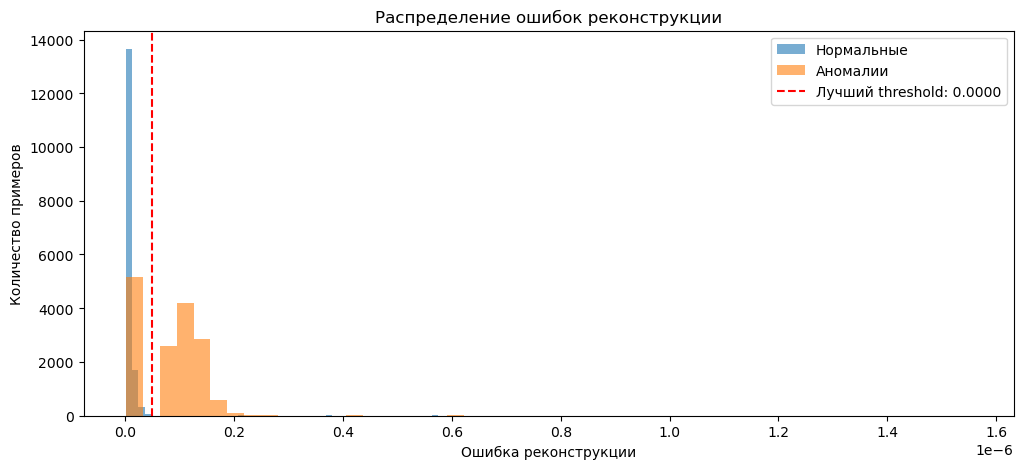

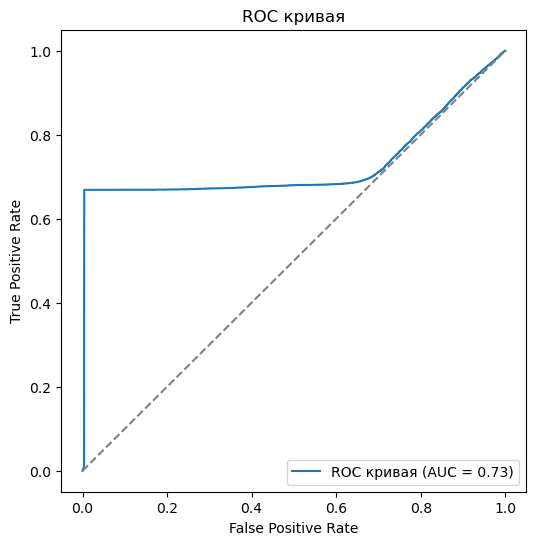

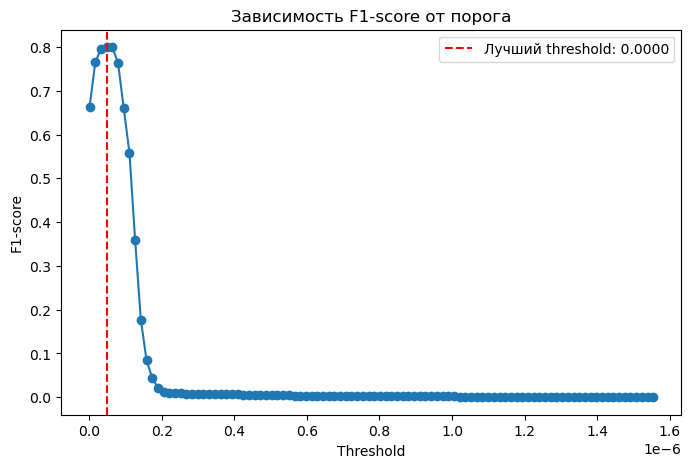

In [18]:
train_attack_category('gamma')


< ---------- brute-http ---------- >


Epoch 1/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 1: Avg AE Loss = 0.1847, Avg Critic Loss = -2.4915, Val Loss = 0.1349


Epoch 2/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 2: Avg AE Loss = 0.1610, Avg Critic Loss = -3.7133, Val Loss = 0.1285


Epoch 3/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 3: Avg AE Loss = 0.1452, Avg Critic Loss = -4.2356, Val Loss = 0.1145


Epoch 4/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 4: Avg AE Loss = 0.1334, Avg Critic Loss = -4.6087, Val Loss = 0.1037


Epoch 5/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 5: Avg AE Loss = 0.1243, Avg Critic Loss = -4.9462, Val Loss = 0.0958


Epoch 6/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 6: Avg AE Loss = 0.1198, Avg Critic Loss = -5.2267, Val Loss = 0.0882


Epoch 7/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 7: Avg AE Loss = 0.1138, Avg Critic Loss = -5.5053, Val Loss = 0.0825


Epoch 8/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 8: Avg AE Loss = 0.1098, Avg Critic Loss = -5.7413, Val Loss = 0.0771


Epoch 9/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 9: Avg AE Loss = 0.1066, Avg Critic Loss = -5.9095, Val Loss = 0.0720


Epoch 10/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 10: Avg AE Loss = 0.1038, Avg Critic Loss = -6.0155, Val Loss = 0.0686


Epoch 11/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 11: Avg AE Loss = 0.1000, Avg Critic Loss = -6.0542, Val Loss = 0.0670


Epoch 12/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 12: Avg AE Loss = 0.0970, Avg Critic Loss = -6.0799, Val Loss = 0.0632


Epoch 13/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 13: Avg AE Loss = 0.0949, Avg Critic Loss = -6.0219, Val Loss = 0.0610


Epoch 14/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 14: Avg AE Loss = 0.0927, Avg Critic Loss = -5.9699, Val Loss = 0.0592


Epoch 15/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 15: Avg AE Loss = 0.0905, Avg Critic Loss = -5.8722, Val Loss = 0.0555


Epoch 16/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 16: Avg AE Loss = 0.0866, Avg Critic Loss = -5.7774, Val Loss = 0.0553


Epoch 17/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 17: Avg AE Loss = 0.0837, Avg Critic Loss = -5.6487, Val Loss = 0.0524


Epoch 18/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 18: Avg AE Loss = 0.0799, Avg Critic Loss = -5.5415, Val Loss = 0.0527


Epoch 19/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 19: Avg AE Loss = 0.0772, Avg Critic Loss = -5.4451, Val Loss = 0.0475


Epoch 20/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 20: Avg AE Loss = 0.0737, Avg Critic Loss = -5.3439, Val Loss = 0.0462


Epoch 21/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 21: Avg AE Loss = 0.0718, Avg Critic Loss = -5.2394, Val Loss = 0.0451


Epoch 22/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 22: Avg AE Loss = 0.0721, Avg Critic Loss = -5.1564, Val Loss = 0.0425


Epoch 23/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 23: Avg AE Loss = 0.0692, Avg Critic Loss = -5.0565, Val Loss = 0.0418


Epoch 24/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 24: Avg AE Loss = 0.0684, Avg Critic Loss = -4.9891, Val Loss = 0.0411


Epoch 25/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 25: Avg AE Loss = 0.0665, Avg Critic Loss = -4.8975, Val Loss = 0.0386


Epoch 26/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 26: Avg AE Loss = 0.0631, Avg Critic Loss = -4.8116, Val Loss = 0.0391


Epoch 27/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 27: Avg AE Loss = 0.0630, Avg Critic Loss = -4.7317, Val Loss = 0.0382


Epoch 28/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 28: Avg AE Loss = 0.0612, Avg Critic Loss = -4.6627, Val Loss = 0.0345


Epoch 29/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 29: Avg AE Loss = 0.0592, Avg Critic Loss = -4.5807, Val Loss = 0.0356


Epoch 30/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 30: Avg AE Loss = 0.0589, Avg Critic Loss = -4.5155, Val Loss = 0.0346


Epoch 31/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 31: Avg AE Loss = 0.0576, Avg Critic Loss = -4.4412, Val Loss = 0.0319


Epoch 32/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 32: Avg AE Loss = 0.0561, Avg Critic Loss = -4.3791, Val Loss = 0.0338


Epoch 33/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 33: Avg AE Loss = 0.0538, Avg Critic Loss = -4.3076, Val Loss = 0.0315


Epoch 34/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 34: Avg AE Loss = 0.0526, Avg Critic Loss = -4.2416, Val Loss = 0.0316


Epoch 35/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 35: Avg AE Loss = 0.0508, Avg Critic Loss = -4.1813, Val Loss = 0.0300


Epoch 36/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 36: Avg AE Loss = 0.0515, Avg Critic Loss = -4.1149, Val Loss = 0.0289


Epoch 37/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 37: Avg AE Loss = 0.0500, Avg Critic Loss = -4.0595, Val Loss = 0.0270


Epoch 38/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 38: Avg AE Loss = 0.0491, Avg Critic Loss = -3.9991, Val Loss = 0.0271


Epoch 39/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 39: Avg AE Loss = 0.0474, Avg Critic Loss = -3.9420, Val Loss = 0.0257


Epoch 40/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 40: Avg AE Loss = 0.0466, Avg Critic Loss = -3.8871, Val Loss = 0.0257


Epoch 41/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 41: Avg AE Loss = 0.0454, Avg Critic Loss = -3.8321, Val Loss = 0.0250


Epoch 42/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 42: Avg AE Loss = 0.0450, Avg Critic Loss = -3.7802, Val Loss = 0.0240


Epoch 43/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 43: Avg AE Loss = 0.0446, Avg Critic Loss = -3.7266, Val Loss = 0.0255


Epoch 44/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 44: Avg AE Loss = 0.0428, Avg Critic Loss = -3.6770, Val Loss = 0.0232


Epoch 45/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 45: Avg AE Loss = 0.0422, Avg Critic Loss = -3.6265, Val Loss = 0.0237


Epoch 46/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 46: Avg AE Loss = 0.0424, Avg Critic Loss = -3.5793, Val Loss = 0.0217


Epoch 47/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 47: Avg AE Loss = 0.0414, Avg Critic Loss = -3.5273, Val Loss = 0.0217


Epoch 48/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 48: Avg AE Loss = 0.0405, Avg Critic Loss = -3.4799, Val Loss = 0.0212


Epoch 49/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 49: Avg AE Loss = 0.0401, Avg Critic Loss = -3.4367, Val Loss = 0.0205


Epoch 50/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 50: Avg AE Loss = 0.0394, Avg Critic Loss = -3.3879, Val Loss = 0.0198


Epoch 51/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 51: Avg AE Loss = 0.0385, Avg Critic Loss = -3.3453, Val Loss = 0.0205


Epoch 52/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 52: Avg AE Loss = 0.0381, Avg Critic Loss = -3.3039, Val Loss = 0.0192


Epoch 53/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 53: Avg AE Loss = 0.0370, Avg Critic Loss = -3.2587, Val Loss = 0.0183


Epoch 54/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 54: Avg AE Loss = 0.0368, Avg Critic Loss = -3.2170, Val Loss = 0.0177


Epoch 55/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 55: Avg AE Loss = 0.0365, Avg Critic Loss = -3.1765, Val Loss = 0.0190


Epoch 56/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 56: Avg AE Loss = 0.0356, Avg Critic Loss = -3.1344, Val Loss = 0.0172


Epoch 57/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 57: Avg AE Loss = 0.0343, Avg Critic Loss = -3.0963, Val Loss = 0.0173


Epoch 58/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 58: Avg AE Loss = 0.0342, Avg Critic Loss = -3.0567, Val Loss = 0.0166


Epoch 59/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 59: Avg AE Loss = 0.0330, Avg Critic Loss = -3.0194, Val Loss = 0.0154


Epoch 60/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 60: Avg AE Loss = 0.0328, Avg Critic Loss = -2.9816, Val Loss = 0.0160


Epoch 61/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 61: Avg AE Loss = 0.0321, Avg Critic Loss = -2.9480, Val Loss = 0.0148


Epoch 62/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 62: Avg AE Loss = 0.0319, Avg Critic Loss = -2.9086, Val Loss = 0.0151


Epoch 63/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 63: Avg AE Loss = 0.0315, Avg Critic Loss = -2.8747, Val Loss = 0.0148


Epoch 64/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 64: Avg AE Loss = 0.0315, Avg Critic Loss = -2.8414, Val Loss = 0.0137


Epoch 65/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 65: Avg AE Loss = 0.0306, Avg Critic Loss = -2.8077, Val Loss = 0.0136


Epoch 66/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 66: Avg AE Loss = 0.0295, Avg Critic Loss = -2.7733, Val Loss = 0.0141


Epoch 67/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 67: Avg AE Loss = 0.0286, Avg Critic Loss = -2.7440, Val Loss = 0.0138


Epoch 68/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 68: Avg AE Loss = 0.0286, Avg Critic Loss = -2.7114, Val Loss = 0.0121


Epoch 69/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 69: Avg AE Loss = 0.0285, Avg Critic Loss = -2.6831, Val Loss = 0.0132


Epoch 70/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 70: Avg AE Loss = 0.0277, Avg Critic Loss = -2.6504, Val Loss = 0.0128


Epoch 71/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 71: Avg AE Loss = 0.0277, Avg Critic Loss = -2.6237, Val Loss = 0.0127


Epoch 72/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 72: Avg AE Loss = 0.0273, Avg Critic Loss = -2.5946, Val Loss = 0.0121


Epoch 73/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 73: Avg AE Loss = 0.0277, Avg Critic Loss = -2.5685, Val Loss = 0.0118


Epoch 74/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 74: Avg AE Loss = 0.0268, Avg Critic Loss = -2.5399, Val Loss = 0.0123


Epoch 75/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 75: Avg AE Loss = 0.0262, Avg Critic Loss = -2.5154, Val Loss = 0.0112


Epoch 76/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 76: Avg AE Loss = 0.0258, Avg Critic Loss = -2.4886, Val Loss = 0.0110


Epoch 77/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 77: Avg AE Loss = 0.0252, Avg Critic Loss = -2.4644, Val Loss = 0.0109


Epoch 78/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 78: Avg AE Loss = 0.0250, Avg Critic Loss = -2.4407, Val Loss = 0.0109


Epoch 79/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 79: Avg AE Loss = 0.0243, Avg Critic Loss = -2.4162, Val Loss = 0.0105


Epoch 80/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 80: Avg AE Loss = 0.0234, Avg Critic Loss = -2.3723, Val Loss = 0.0093


Epoch 81/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 81: Avg AE Loss = 0.0216, Avg Critic Loss = -2.1836, Val Loss = 0.0087


Epoch 82/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 82: Avg AE Loss = 0.0213, Avg Critic Loss = -2.1481, Val Loss = 0.0080


Epoch 83/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 83: Avg AE Loss = 0.0211, Avg Critic Loss = -2.1179, Val Loss = 0.0081


Epoch 84/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 84: Avg AE Loss = 0.0205, Avg Critic Loss = -2.0891, Val Loss = 0.0076


Epoch 85/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 85: Avg AE Loss = 0.0195, Avg Critic Loss = -2.0624, Val Loss = 0.0076


Epoch 86/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 86: Avg AE Loss = 0.0196, Avg Critic Loss = -2.0381, Val Loss = 0.0080


Epoch 87/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 87: Avg AE Loss = 0.0201, Avg Critic Loss = -2.0160, Val Loss = 0.0073


Epoch 88/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 88: Avg AE Loss = 0.0186, Avg Critic Loss = -1.9937, Val Loss = 0.0076


Epoch 89/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 89: Avg AE Loss = 0.0190, Avg Critic Loss = -1.9724, Val Loss = 0.0072


Epoch 90/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 90: Avg AE Loss = 0.0176, Avg Critic Loss = -1.9521, Val Loss = 0.0069


Epoch 91/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 91: Avg AE Loss = 0.0180, Avg Critic Loss = -1.9332, Val Loss = 0.0066


Epoch 92/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 92: Avg AE Loss = 0.0181, Avg Critic Loss = -1.9136, Val Loss = 0.0070


Epoch 93/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 93: Avg AE Loss = 0.0171, Avg Critic Loss = -1.8956, Val Loss = 0.0067


Epoch 94/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 94: Avg AE Loss = 0.0171, Avg Critic Loss = -1.8777, Val Loss = 0.0064


Epoch 95/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 95: Avg AE Loss = 0.0171, Avg Critic Loss = -1.8609, Val Loss = 0.0064


Epoch 96/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 96: Avg AE Loss = 0.0171, Avg Critic Loss = -1.8430, Val Loss = 0.0063


Epoch 97/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 97: Avg AE Loss = 0.0161, Avg Critic Loss = -1.7547, Val Loss = 0.0048


Epoch 98/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 98: Avg AE Loss = 0.0135, Avg Critic Loss = -1.4774, Val Loss = 0.0040


Epoch 99/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 99: Avg AE Loss = 0.0129, Avg Critic Loss = -1.4779, Val Loss = 0.0040


Epoch 100/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 100: Avg AE Loss = 0.0120, Avg Critic Loss = -1.4617, Val Loss = 0.0040


Epoch 101/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 101: Avg AE Loss = 0.0114, Avg Critic Loss = -1.4563, Val Loss = 0.0040


Epoch 102/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 102: Avg AE Loss = 0.0110, Avg Critic Loss = -1.4540, Val Loss = 0.0040


Epoch 103/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 103: Avg AE Loss = 0.0112, Avg Critic Loss = -1.4516, Val Loss = 0.0039


Epoch 104/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 104: Avg AE Loss = 0.0112, Avg Critic Loss = -1.4494, Val Loss = 0.0039


Epoch 105/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 105: Avg AE Loss = 0.0111, Avg Critic Loss = -1.4471, Val Loss = 0.0039


Epoch 106/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 106: Avg AE Loss = 0.0113, Avg Critic Loss = -1.4448, Val Loss = 0.0039


Epoch 107/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 107: Avg AE Loss = 0.0110, Avg Critic Loss = -1.4428, Val Loss = 0.0039


Epoch 108/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 108: Avg AE Loss = 0.0114, Avg Critic Loss = -1.4405, Val Loss = 0.0039


Epoch 109/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 109: Avg AE Loss = 0.0114, Avg Critic Loss = -1.4383, Val Loss = 0.0039


Epoch 110/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 110: Avg AE Loss = 0.0110, Avg Critic Loss = -1.4363, Val Loss = 0.0038


Epoch 111/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 111: Avg AE Loss = 0.0105, Avg Critic Loss = -1.4345, Val Loss = 0.0039


Epoch 112/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 112: Avg AE Loss = 0.0112, Avg Critic Loss = -1.4323, Val Loss = 0.0038


Epoch 113/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 113: Avg AE Loss = 0.0112, Avg Critic Loss = -1.4304, Val Loss = 0.0038


Epoch 114/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 114: Avg AE Loss = 0.0114, Avg Critic Loss = -1.4284, Val Loss = 0.0038


Epoch 115/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 115: Avg AE Loss = 0.0113, Avg Critic Loss = -1.4265, Val Loss = 0.0038


Epoch 116/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 116: Avg AE Loss = 0.0110, Avg Critic Loss = -1.4246, Val Loss = 0.0038


Epoch 117/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 117: Avg AE Loss = 0.0107, Avg Critic Loss = -1.4227, Val Loss = 0.0038


Epoch 118/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 118: Avg AE Loss = 0.0111, Avg Critic Loss = -1.4208, Val Loss = 0.0038


Epoch 119/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 119: Avg AE Loss = 0.0115, Avg Critic Loss = -1.4189, Val Loss = 0.0038


Epoch 120/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 120: Avg AE Loss = 0.0112, Avg Critic Loss = -1.4171, Val Loss = 0.0038


Epoch 121/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 121: Avg AE Loss = 0.0109, Avg Critic Loss = -1.4153, Val Loss = 0.0037


Epoch 122/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 122: Avg AE Loss = 0.0103, Avg Critic Loss = -1.4135, Val Loss = 0.0037


Epoch 123/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 123: Avg AE Loss = 0.0109, Avg Critic Loss = -1.4116, Val Loss = 0.0037


Epoch 124/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 124: Avg AE Loss = 0.0105, Avg Critic Loss = -1.4099, Val Loss = 0.0037


Epoch 125/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 125: Avg AE Loss = 0.0107, Avg Critic Loss = -1.4080, Val Loss = 0.0037


Epoch 126/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 126: Avg AE Loss = 0.0109, Avg Critic Loss = -1.4063, Val Loss = 0.0037


Epoch 127/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 127: Avg AE Loss = 0.0107, Avg Critic Loss = -1.4045, Val Loss = 0.0037


Epoch 128/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 128: Avg AE Loss = 0.0103, Avg Critic Loss = -1.4029, Val Loss = 0.0037


Epoch 129/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 129: Avg AE Loss = 0.0108, Avg Critic Loss = -1.4010, Val Loss = 0.0037


Epoch 130/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 130: Avg AE Loss = 0.0108, Avg Critic Loss = -1.3993, Val Loss = 0.0037


Epoch 131/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 131: Avg AE Loss = 0.0106, Avg Critic Loss = -1.3977, Val Loss = 0.0037


Epoch 132/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 132: Avg AE Loss = 0.0109, Avg Critic Loss = -1.3960, Val Loss = 0.0036


Epoch 133/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 133: Avg AE Loss = 0.0107, Avg Critic Loss = -1.3942, Val Loss = 0.0036


Epoch 134/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 134: Avg AE Loss = 0.0102, Avg Critic Loss = -1.3927, Val Loss = 0.0036


Epoch 135/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 135: Avg AE Loss = 0.0108, Avg Critic Loss = -1.3909, Val Loss = 0.0036


Epoch 136/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 136: Avg AE Loss = 0.0106, Avg Critic Loss = -1.3892, Val Loss = 0.0036


Epoch 137/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 137: Avg AE Loss = 0.0106, Avg Critic Loss = -1.3876, Val Loss = 0.0036


Epoch 138/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 138: Avg AE Loss = 0.0105, Avg Critic Loss = -1.3859, Val Loss = 0.0036


Epoch 139/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 139: Avg AE Loss = 0.0107, Avg Critic Loss = -1.3843, Val Loss = 0.0036


Epoch 140/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 140: Avg AE Loss = 0.0105, Avg Critic Loss = -1.3827, Val Loss = 0.0036


Epoch 141/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 141: Avg AE Loss = 0.0102, Avg Critic Loss = -1.3811, Val Loss = 0.0036


Epoch 142/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 142: Avg AE Loss = 0.0100, Avg Critic Loss = -1.3794, Val Loss = 0.0036


Epoch 143/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 143: Avg AE Loss = 0.0101, Avg Critic Loss = -1.3778, Val Loss = 0.0036


Epoch 144/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 144: Avg AE Loss = 0.0099, Avg Critic Loss = -1.3763, Val Loss = 0.0035


Epoch 145/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 145: Avg AE Loss = 0.0100, Avg Critic Loss = -1.3746, Val Loss = 0.0035


Epoch 146/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 146: Avg AE Loss = 0.0098, Avg Critic Loss = -1.3731, Val Loss = 0.0035


Epoch 147/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 147: Avg AE Loss = 0.0094, Avg Critic Loss = -1.3714, Val Loss = 0.0035


Epoch 148/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 148: Avg AE Loss = 0.0093, Avg Critic Loss = -1.3700, Val Loss = 0.0035


Epoch 149/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 149: Avg AE Loss = 0.0093, Avg Critic Loss = -1.3683, Val Loss = 0.0035


Epoch 150/150:   0%|          | 0/11 [00:00<?, ?batch/s]

- Epoch 150: Avg AE Loss = 0.0098, Avg Critic Loss = -1.3668, Val Loss = 0.0035
Обучение завершено.
AUROC: 0.8326
Лучший threshold: 0.0035
Accuracy: 0.7863
Precision: 0.8385
Recall: 0.7527
F1: 0.7933
Матрица ошибок:
TN: 324.0000
FP: 68.0000
FN: 116.0000
TP: 353.0000


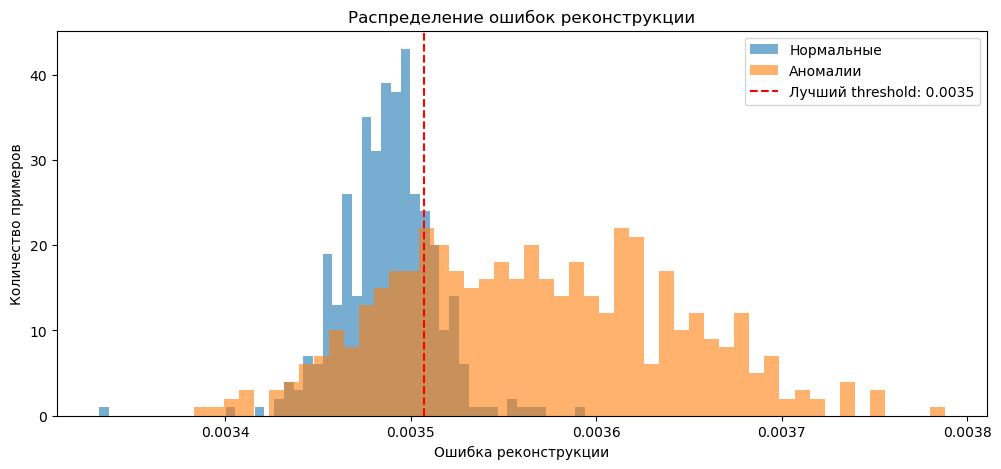

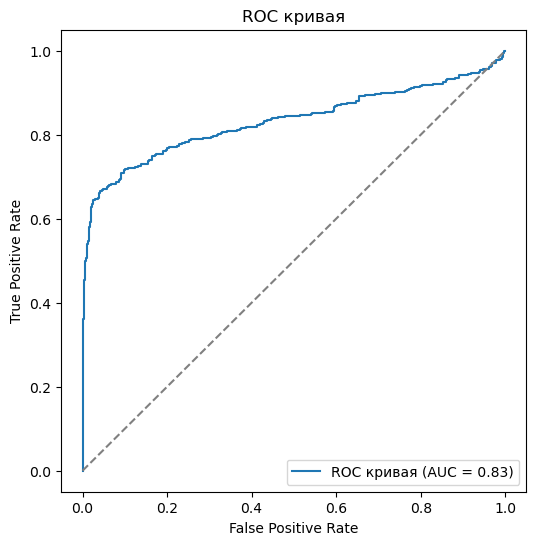

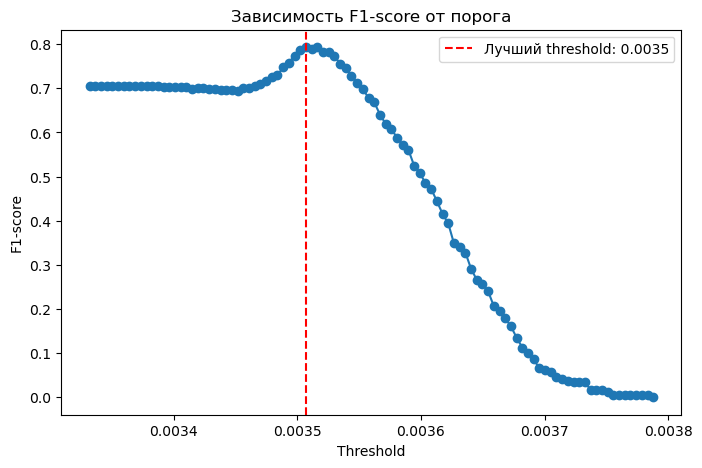

In [18]:
train_attack_category('normal')

In [24]:
# Создаем DataFrame и сохраняем в CSV
base_dir = 'ARP-STP-n_packets=2_l=100'
results_df = pd.DataFrame(results)
results_df.to_csv(f'{base_dir}_attack_metrics_report.csv', index=False)
print(f"\nMetrics saved to {base_dir}_attack_metrics_report.csv")


Metrics saved to n_packets=5_l=100_attack_metrics_report.csv


In [25]:
results_df

,Attack Category,AUROC,Accuracy,Precision,Recall,F1 Score,True Negative,False Positive,False Negative,True Positive,ROC AUC
0,botnet-ares,0.446798,0.477211,0.477171,1.000000,0.646060,1,6882,0,6281,0.446798
1,brute-ftp,0.828842,0.939397,0.939500,0.999884,0.968752,0,554,1,8603,0.828842
2,brute-http,0.832601,0.786295,0.838480,0.752665,0.793258,324,68,116,353,0.832601
3,brute-ssh,0.788103,0.889950,0.890089,0.999824,0.941771,0,702,1,5685,0.788103
4,inf-dropbox,0.476054,0.664759,0.664815,0.999747,0.798584,1,1991,1,3949,0.476054
5,inf-usb,0.562467,0.965696,0.968043,0.996573,0.982101,38,48,5,1454,0.562467
6,sql-inj,0.949074,0.952381,0.900000,1.000000,0.947368,22,2,0,18,0.949074
7,xss,0.533618,0.572271,0.573964,0.994872,0.727955,0,144,1,194,0.533618
